In [1]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

band 1,  elat10, 25 frames,mask 43.83 % pixels
band 1,  elat30, 10 frames,mask 49.58 % pixels
band 1, BootesB, 30 frames,mask 57.65 % pixels
band 1, BootesA, 29 frames,mask 46.60 % pixels
band 1,   SWIRE, 26 frames,mask 56.26 % pixels
band 2,  elat10, 25 frames,mask 41.94 % pixels
band 2,  elat30, 10 frames,mask 48.50 % pixels
band 2, BootesB, 29 frames,mask 56.40 % pixels
band 2, BootesA, 28 frames,mask 44.73 % pixels
band 2,   SWIRE, 26 frames,mask 54.90 % pixels


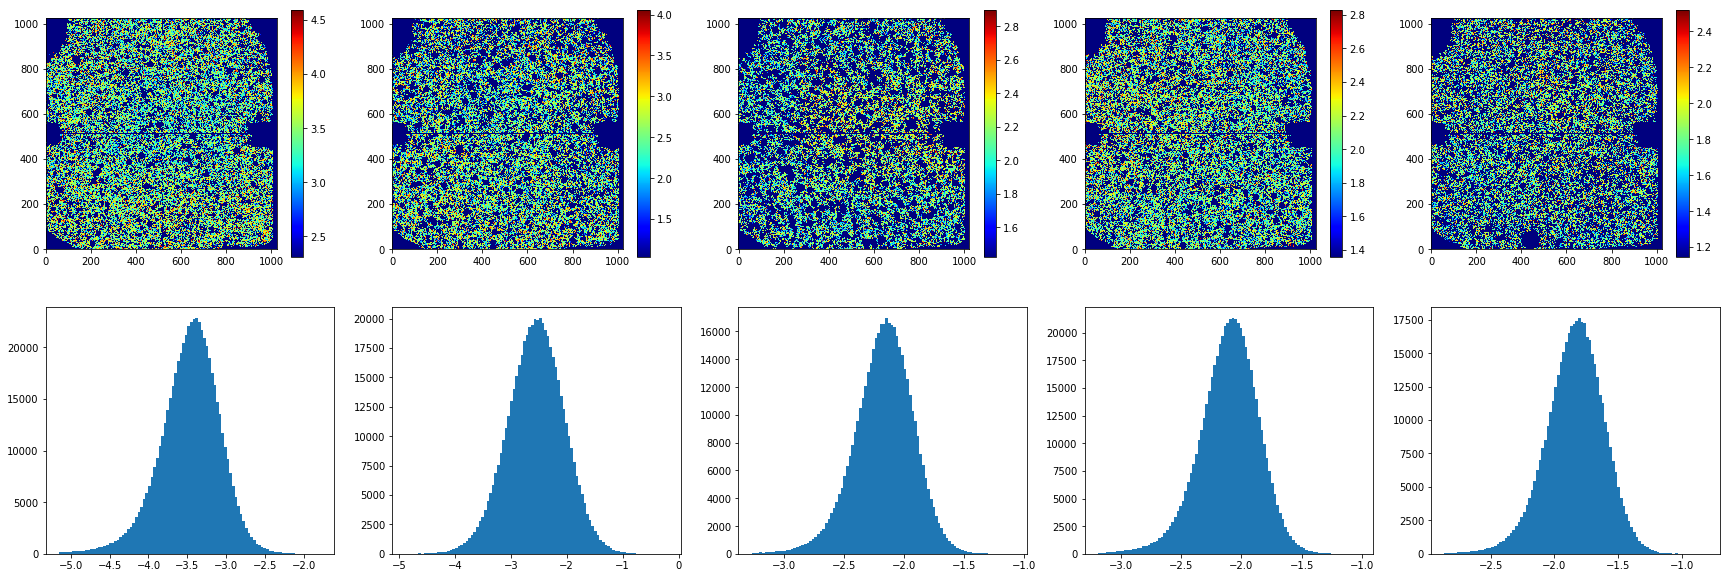

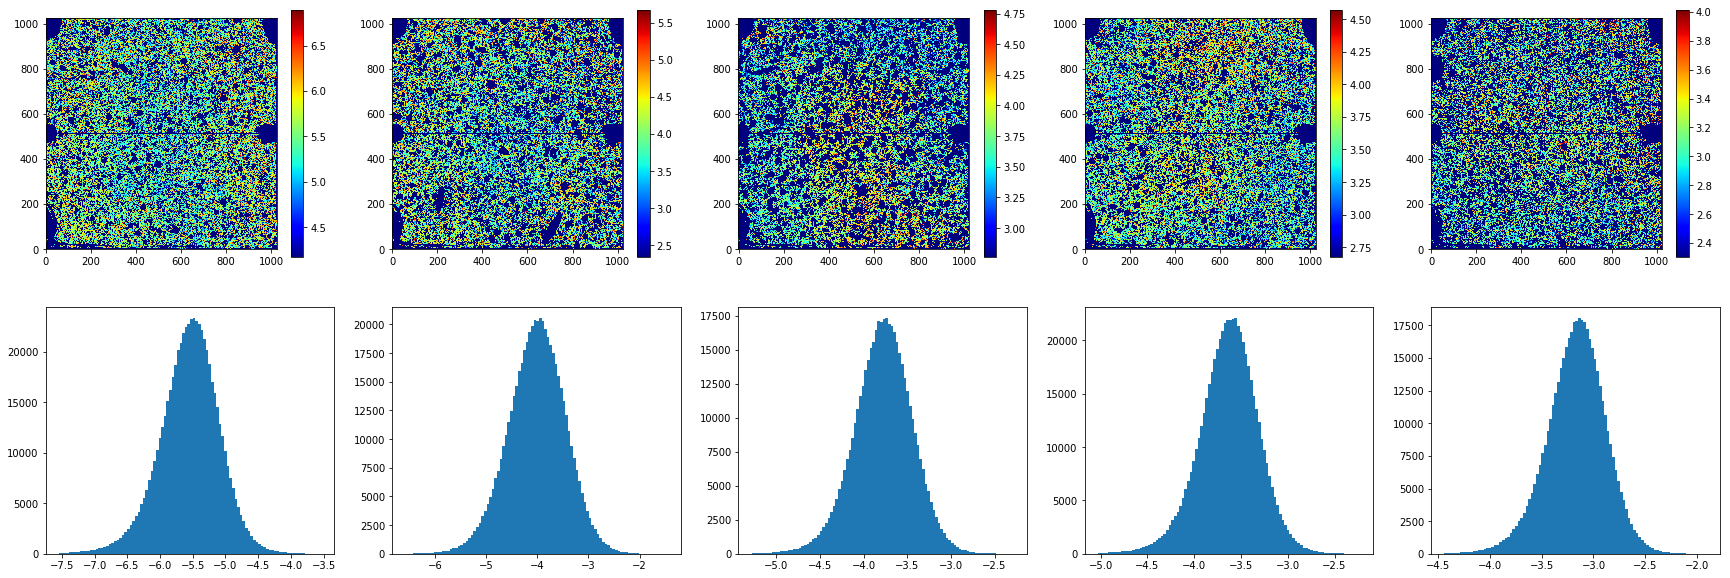

In [10]:
for inst in [1,2]:
    data = data_maps[inst]
    fig, ax = plt.subplots(2,5, figsize=(30,10))
    for ifield in [4,5,6,7,8]:
        mapin = data.stackmapdat[ifield]['map'].copy()
        strmask = data.stackmapdat[ifield]['strmask'].copy()
        mask_inst = data.stackmapdat[ifield]['mask_inst'].copy()
        ax[1][ifield-4].hist(mapin[strmask*mask_inst==1],bins=100)
        imageclip(-mapin*strmask*mask_inst,ax=ax[0][ifield-4])
        
        maskf = 1 - np.sum(mask_inst*strmask) / np.size(mapin)
        print('band %d, %7s, %d frames,mask %.2f %% pixels'\
              %(inst, fieldnamedict[ifield], data.stackmapdat[ifield]['Nfr'], maskf*100))
    print('====================================================')

# Calibration from 2MASS Photometry

https://www.eaobservatory.org/jcmt/faq/how-can-i-convert-from-mjybeam-to-mjy/

1.133 = $\pi$/4ln2

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils_plotting.py:78: RuntimeWarning: invalid value encountered in greater_equal
  spp = np.where(y>=0)[0]
/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils_plotting.py:79: RuntimeWarning: invalid value encountered in less
  spn = np.where(y<0)[0]
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:106: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


band 1 apf2nWpm2psr:

4:-448.60, 5:-333.58, 6:-461.59, 7:-339.27, 8:-361.43


band 2 apf2nWpm2psr:

4:-122.28, 5:-118.09, 6:-137.84, 7:-111.95, 8:-115.39




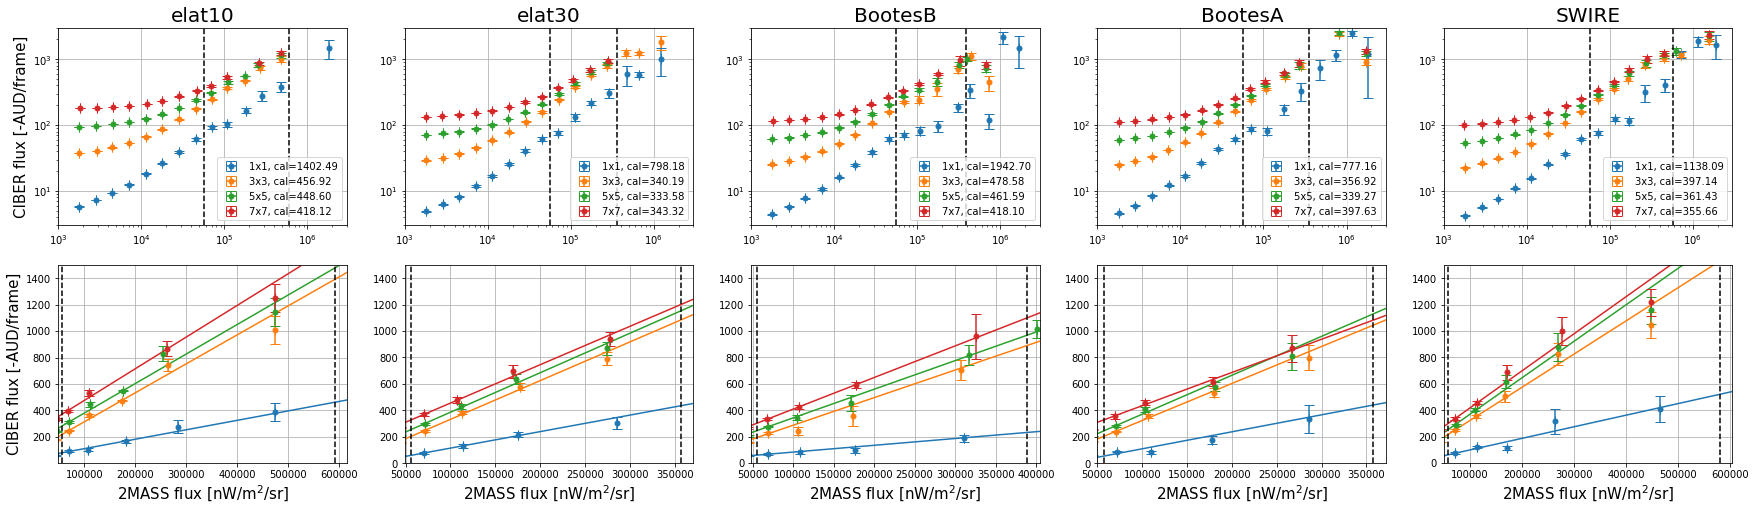

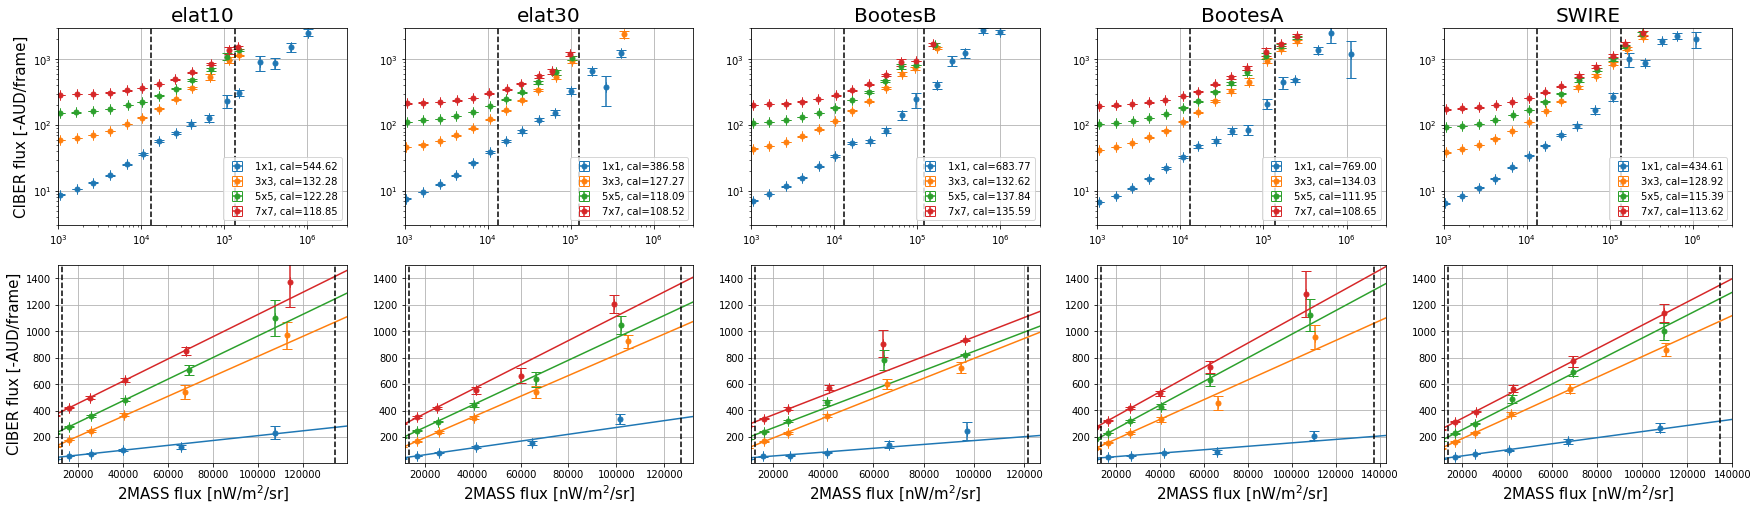

In [3]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

for inst in [1,2]:
    data = data_maps[inst]
    if inst==1:
        fitmaglim = (10.5,13)
    else:
        fitmaglim = (11.5,14)
    
    calfac = []
    fig, ax = plt.subplots(2,5,figsize=(30,8))
    for ifield in [4,5,6,7,8]:

        mapin = -data.stackmapdat[ifield]['map'].copy()
        mask_inst =  data.stackmapdat[ifield]['mask_inst'].copy()
        strnum = data.stackmapdat[ifield]['strnum'].copy()

        df = pd.read_csv(mypaths['2Mcatdat'] + fieldnamedict[ifield] + '.csv')
        xs, ys = np.array(df['y'+str(inst)]), np.array(df['x'+str(inst)])
        ms = np.array(df['I']) if inst==1 else np.array(df['H'])

        sp = np.where((xs>=3) & (xs<1020) & (ys>=3) & (ys<1020))[0]
        xs, ys, ms = xs[sp], ys[sp], ms[sp]
        Is = ABmag2Iciber(inst, ms)

        mbinedges = np.arange(9,17.5,0.5)
        mbins = (mbinedges[1:] + mbinedges[:-1]) / 2
        stampsize_arr = np.array([1,3,5,7])

        Ith_arr = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Icb_arr = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Ith_err = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Icb_err = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        for im, (m_min, m_max) in enumerate(zip(mbinedges[:-1], mbinedges[1:])):

            msp = np.where((ms >= m_min) & (ms < m_max))[0]    
            for ist, stampsize in enumerate(stampsize_arr):

                Iths, Icbs = [], []
                for x,y,m,I in zip(xs[msp], ys[msp], ms[msp], Is[msp]):
                    x, y = int(round(x)), int(round(y))
                    xmin, xmax = x-stampsize//2, x+stampsize//2
                    ymin, ymax = y-stampsize//2, y+stampsize//2

                    if np.any(mask_inst[xmin:xmax+1,ymin:ymax+1]==0):
                        continue

                    Iths.append(I)
                    Icbs.append(np.sum(mapin[xmin:xmax+1,ymin:ymax+1]))

                Iths, Icbs = np.array(Iths), np.array(Icbs)
                if len(Iths)==0:
                    continue

                Q1 = np.percentile(Icbs, 25)
                Q3 = np.percentile(Icbs, 75)
                clipmin = Q1 - 3 * (Q3 - Q1)
                clipmax = Q3 + 3 * (Q3 - Q1)
                spclip = np.where((Icbs > clipmin) & (Icbs < clipmax))[0]
                Iths, Icbs = Iths[spclip], Icbs[spclip]
                if len(Iths)==0:
                    continue

                Ith_arr[ist, im] = np.mean(Iths)
                Icb_arr[ist, im] = np.mean(Icbs)
                Ith_err[ist, im] = np.std(Iths)/np.sqrt(len(Iths))
                Icb_err[ist, im] = np.std(Icbs)/np.sqrt(len(Icbs))

        Ith_arr[Ith_arr==0] = np.nan
        Icb_arr[Icb_arr==0] = np.nan
        Ith_err[Ith_arr==0] = np.nan
        Icb_err[Icb_arr==0] = np.nan

        Fth_arr = Iciber2FJy(inst, Ith_arr)
        Fth_err = Iciber2FJy(inst, Ith_err)

        for ist, stampsize in enumerate(stampsize_arr):
            spfit = np.where((mbins > fitmaglim[0]) & (mbins < fitmaglim[1])\
                             & (Fth_arr[ist]==Fth_arr[ist]))[0]
            fitparam = np.polyfit(Icb_arr[ist,spfit], Ith_arr[ist,spfit], w=1/Icb_err[ist,spfit], deg=1)
            yfit = np.logspace(np.log10(np.nanmin(Icb_arr)), np.log10(np.nanmax(Icb_arr)), 100)
            xfit = fitparam[0]*yfit + fitparam[1]
            if stampsize ==5:
                calfac.append(fitparam[0])
            plot_err_log(Ith_arr[ist], Icb_arr[ist], Icb_err[ist], xerr=Fth_err[ist],
                         ax=ax[0][ifield-4], color='C'+str(ist),
                         label='%dx%d, cal=%.2f'%(stampsize,stampsize,fitparam[0]))
            plot_err_log(Ith_arr[ist], Icb_arr[ist], Icb_err[ist], xerr=Fth_err[ist],
                         ax=ax[1][ifield-4], color='C'+str(ist),
                         label='%dx%d, cal=%.2f'%(stampsize,stampsize,fitparam[0]))
            ax[1][ifield-4].plot(xfit, yfit, color='C'+str(ist))

        ax[0][ifield-4].axvline(Ith_arr[0,spfit[0]]*1.25, c='k', ls='--')
        ax[0][ifield-4].axvline(Ith_arr[0,spfit[-1]]*0.8, c='k', ls='--')
        ax[1][ifield-4].axvline(Ith_arr[0,spfit[0]]*1.25, c='k', ls='--')
        ax[1][ifield-4].axvline(Ith_arr[0,spfit[-1]]*0.8, c='k', ls='--')

        ax[0][ifield-4].legend(loc=4)
        ax[0][ifield-4].grid()
        ax[0][ifield-4].set_xlim([1e3, 3e6])
        ax[0][ifield-4].set_ylim([3e0, 3e3])
        ax[0][ifield-4].set_title(fieldnamedict[ifield], fontsize=20)

        ax[1][ifield-4].grid()
        ax[1][ifield-4].set_xlim([Ith_arr[0,spfit[-1]]*0.7, Ith_arr[0,spfit[0]]*1.3])
        ax[1][ifield-4].set_ylim([0, 1500])
        ax[1][ifield-4].set_xlabel('2MASS flux [nW/m$^2$/sr]', fontsize=15)
        ax[1][ifield-4].set_xscale('linear')
        ax[1][ifield-4].set_yscale('linear')
    ax[0][0].set_ylabel('CIBER flux [-AUD/frame]', fontsize=15)
    ax[1][0].set_ylabel('CIBER flux [-AUD/frame]', fontsize=15)
    
    plt.savefig('plots/paperfig/calfac_TM%d.pdf'%(inst), dpi = 200, bbox_inches='tight')
    
    print('band %d apf2nWpm2psr:\n'%inst)
    for i,ifield in enumerate([4,5,6,7,8]):
        if i!=0:
            print(', ', end='')
        print('%d:-%.2f'%(ifield,calfac[i]), end='')
    print('\n\n')

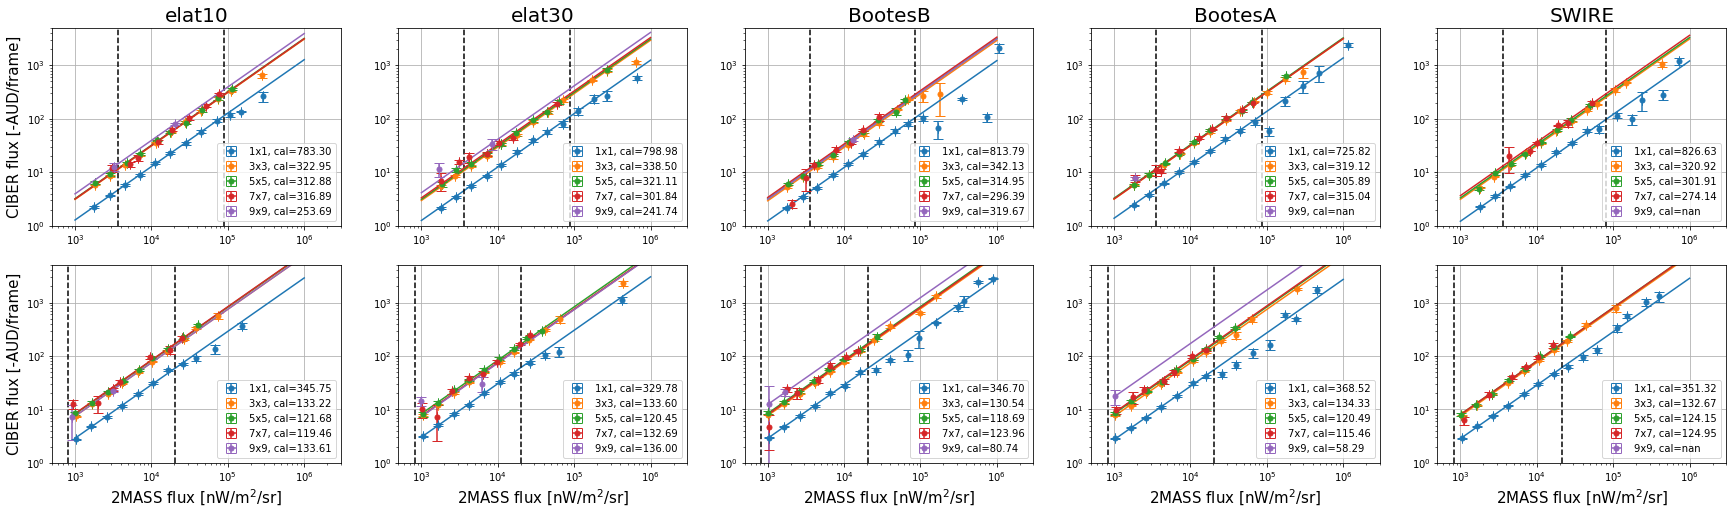

In [262]:
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}
fig, ax = plt.subplots(2,5,figsize=(30,8))
calfac_data = {}
for inst in [1,2]:
    calfac_data[inst] = {}
    data = data_maps[inst]
    if inst==1:
        fitmaglim = (12.5,16)
    else:
        fitmaglim = (13.5,17)
        
    for ifield in [4,5,6,7,8]:
        calfac_data[inst][ifield] = {}
        mapin = -data.stackmapdat[ifield]['map'].copy()
        mask_inst =  data.stackmapdat[ifield]['mask_inst'].copy()
        strnum = data.stackmapdat[ifield]['strnum'].copy()
        strmask = data.stackmapdat[ifield]['strmask'].copy()
        meammap = np.mean(mapin[strmask*mask_inst==1])
        
        df = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
        xs, ys = np.array(df['y'+str(inst)]), np.array(df['x'+str(inst)])
        ms = np.array(df['I_comb']) if inst==1 else np.array(df['H_comb'])

        sp = np.where((xs>=4) & (xs<1019) & (ys>=4) & (ys<1019))[0]
        xs, ys, ms = xs[sp], ys[sp], ms[sp]
        rs = get_mask_radius_th(ifield, ms)
        Is = ABmag2Iciber(inst, ms)

        mbinedges = np.arange(9,17.5,0.5)
        mbins = (mbinedges[1:] + mbinedges[:-1]) / 2
        stampsize_arr = np.array([1,3,5,7,9])

        Ith_arr = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Icb_arr = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Ith_err = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Icb_err = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        for im, (m_min, m_max) in enumerate(zip(mbinedges[:-1], mbinedges[1:])):
            print('TM%d, %s, %d/%d mbins'%(inst, fieldnamedict[ifield],im,len(mbins)))
            msp = np.where((ms >= m_min) & (ms < m_max))[0]    
            Iths_data = {1:[],3:[],5:[],7:[],9:[]}
            Icbs_data = {1:[],3:[],5:[],7:[],9:[]}
            for i,(x,y,m,r,I) in enumerate(zip(xs[msp], ys[msp], ms[msp], rs[msp], Is[msp])):
                x, y = int(round(x)), int(round(y))
                radmap = make_radius_map(mapin, x,y)
                sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
                maski = strmask * mask_inst
                maski[sp1] = 1
                mapi = (mapin-meammap) * maski
                for ist, stampsize in enumerate(stampsize_arr):
                    xmin, xmax = x-stampsize//2, x+stampsize//2
                    ymin, ymax = y-stampsize//2, y+stampsize//2
                    if np.any(mapi[xmin:xmax+1,ymin:ymax+1]==0):
                        continue
                    Iths_data[stampsize].append(I)
                    Icbs_data[stampsize].append(np.sum(mapi[xmin:xmax+1,ymin:ymax+1]))
                
            for ist, stampsize in enumerate(stampsize_arr):
                Iths = np.array(Iths_data[stampsize])
                Icbs = np.array(Icbs_data[stampsize])
                if len(Iths)==0:
                    continue

                Q1 = np.percentile(Icbs, 25)
                Q3 = np.percentile(Icbs, 75)
                clipmin = Q1 - 3 * (Q3 - Q1)
                clipmax = Q3 + 3 * (Q3 - Q1)
                spclip = np.where((Icbs > clipmin) & (Icbs < clipmax))[0]
                Iths, Icbs = Iths[spclip], Icbs[spclip]
                if len(Iths)==0:
                    continue

                Ith_arr[ist, im] = np.mean(Iths)
                Icb_arr[ist, im] = np.mean(Icbs)
                Ith_err[ist, im] = np.std(Iths)/np.sqrt(len(Iths))
                Icb_err[ist, im] = np.std(Icbs)/np.sqrt(len(Icbs))

        Ith_arr[Ith_arr==0] = np.nan
        Icb_arr[Icb_arr==0] = np.nan
        Ith_err[Ith_arr==0] = np.nan
        Icb_err[Icb_arr==0] = np.nan

        Fth_arr = Iciber2FJy(inst, Ith_arr)
        Fth_err = Iciber2FJy(inst, Ith_err)

        for ist, stampsize in enumerate(stampsize_arr):
            spfit = np.where((mbins > fitmaglim[0]) & (mbins < fitmaglim[1])\
                             & (Fth_arr[ist]==Fth_arr[ist]))[0]
            calfac = np.mean(Ith_arr[ist,spfit]/ Icb_arr[ist,spfit])
            calfac_data[inst][ifield][ist] = calfac
            plot_err_log(Ith_arr[ist], Icb_arr[ist], Icb_err[ist], xerr=Fth_err[ist],
                         ax=ax[inst-1][ifield-4], color='C'+str(ist),
                         label='%dx%d, cal=%.2f'%(stampsize,stampsize,calfac))
            ax[inst-1][ifield-4].loglog([1e3,1e6],[1e3/calfac,1e6/calfac],color='C'+str(ist))
            if ist == 0:
                ax[inst-1][ifield-4].axvline(Ith_arr[0,spfit[0]]*1.25, c='k', ls='--')
                ax[inst-1][ifield-4].axvline(Ith_arr[0,spfit[-1]]*0.8, c='k', ls='--')

        ax[inst-1][ifield-4].legend(loc=4)
        ax[inst-1][ifield-4].grid()
        ax[inst-1][ifield-4].set_xlim([5e2, 3e6])
        ax[inst-1][ifield-4].set_ylim([1e0, 5e3])
        ax[0][ifield-4].set_title(fieldnamedict[ifield], fontsize=20)

        ax[1][ifield-4].set_xlabel('2MASS flux [nW/m$^2$/sr]', fontsize=15)
ax[0][0].set_ylabel('CIBER flux [-AUD/frame]', fontsize=15)
ax[1][0].set_ylabel('CIBER flux [-AUD/frame]', fontsize=15)
plt.savefig('plots/paperfig/calfac.pdf', dpi = 200, bbox_inches='tight')
clear_output()

elat10, Isky(I)=695.08,Isky(H)=496.26, I_raw/I_AGsub=1.027
elat30, Isky(I)=495.59,Isky(H)=359.09, I_raw/I_AGsub=1.049
BootesB, Isky(I)=399.77,Isky(H)=292.75, I_raw/I_AGsub=1.062
SWIRE, Isky(I)=335.10,Isky(H)=248.39, I_raw/I_AGsub=1.018


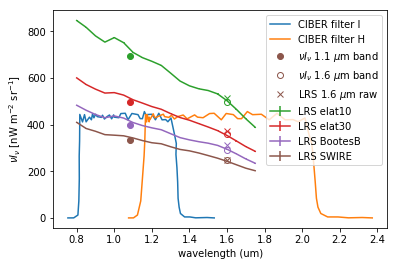

In [26]:
from utils import *
datadir = mypaths['ciberdir'] + 'data/'

d = np.loadtxt(datadir + 'ciber_filter_I.txt', skiprows=1)
wl_filtI = d[:,0]/1e4
filtI = d[:,1]
d = np.loadtxt(datadir + 'ciber_filter_H.txt', skiprows=1)
wl_filtH = d[:,0]/1e4
filtH = d[:,1]

plt.plot(wl_filtI, filtI*500,label='CIBER filter I')
plt.plot(wl_filtH, filtI*500,label='CIBER filter H')

d = np.loadtxt(datadir + 'LRS_H-band_raw_profile.txt', skiprows=1)
Hband_time, Hband_Itime = d[:,0], d[:,1]
d = np.loadtxt(datadir + 'LRS_sky_brightness.txt', skiprows=1)
wl_LRS = d[:,0]

for i,(idx,name, ts, te) in enumerate(zip((5,7,9,11),('elat10','elat30','BootesB','SWIRE'),
                                 (387,450,513,655),(436,500,569,705))):
    Isky_H_raw = np.mean(Hband_Itime[(Hband_time>ts) & (Hband_time<te)])
    Isky_H_agsub = d[np.where(wl_LRS==1.6)[0][0],idx]
    
    Iinterp = np.interp(wl_filtI, wl_LRS, d[:,idx])
    Hinterp = np.interp(wl_filtH, wl_LRS, d[:,idx])
    Isky_I = np.sum(Iinterp * wl_filtI)/np.sum(wl_filtI)
    Isky_H = np.sum(Hinterp * wl_filtH)/np.sum(wl_filtH)
    
    if name!='SWIRE':
        plt.plot([np.mean(wl_filtI)], [Isky_I],'o',c='C'+str(i+2))
        plt.plot([np.mean(wl_filtH)], [Isky_H],'o',markerfacecolor='none', c='C'+str(i+2))
        plt.errorbar(wl_LRS,d[:,idx],d[:,idx+1],label='LRS ' + name,c='C'+str(i+2))
        plt.plot([1.6], [Isky_H_raw],'x',c='C'+str(i+2))

    else:
        plt.plot([np.mean(wl_filtI)], [Isky_I],'o',c='C'+str(i+2),label=r'$\nu I_\nu$ 1.1 $\mu$m band')
        plt.plot([np.mean(wl_filtH)], [Isky_H],'o',markerfacecolor='none',
                 c='C'+str(i+2), label=r'$\nu I_\nu$ 1.6 $\mu$m band')
        plt.errorbar(wl_LRS,d[:,idx],d[:,idx+1],label='LRS ' + name,c='C'+str(i+2))
        plt.plot([1.6], [Isky_H_raw],'x',c='C'+str(i+2),label=r'LRS 1.6 $\mu$m raw')
    print('%s, Isky(I)=%.2f,Isky(H)=%.2f, I_raw/I_AGsub=%.3f'\
          %(name, Isky_I,Isky_H,Isky_H_raw/Isky_H_agsub))

plt.xlabel('wavelength (um)')
plt.ylabel(r'$\nu I_\nu$ [nW m$^{-2}$ sr$^{-1}$]')
plt.legend()
plt.savefig('/Users/ytcheng/Desktop/LRS_nuInu', dpi = 200, bbox_inches='tight')

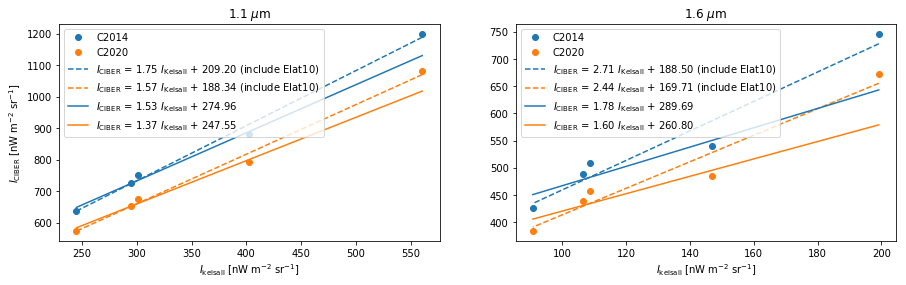

In [20]:
from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

fig, ax = plt.subplots(1,2,figsize=(15,4))
C14_C20 = (-170.36*2.03)/(-311.35)
for inst in [1,2]:
    I14_arr = []
    I20_arr = []
    Izl_arr = []
    for ifield in [4,5,6,7,8]:
        I20, ZL = load_processed_images(data_maps,
                              return_names=[(inst,ifield,'mean_cb'),
                                            (inst,ifield,'kelsall')])
        I20_arr.append(I20)
        I14_arr.append(I20 * C14_C20)
        Izl_arr.append(np.mean(ZL))
    I20_arr, I14_arr, Izl_arr = np.array(I20_arr), np.array(I14_arr), np.array(Izl_arr)
    ax[inst-1].plot(Izl_arr,I14_arr,'C0o',label='C2014')
    ax[inst-1].plot(Izl_arr,I20_arr,'C1o',label='C2020')
    
#     off14 = np.sqrt(np.mean((I14_arr[1:] - Izl_arr[1:])**2))
#     ax[inst-1].plot(Izl_arr, Izl_arr+off14,'C0')
#     off20 = np.sqrt(np.mean((I20_arr[1:] - Izl_arr[1:])**2))
#     ax[inst-1].plot(Izl_arr, Izl_arr+off20,'C1')

    p = np.polyfit(Izl_arr, I14_arr, 1)
    fit = np.polyval(p,Izl_arr)
    ax[inst-1].plot(Izl_arr, fit,'C0--', 
                    label=r'$I_{\rm CIBER}$ = %.2f $I_{\rm Kelsall}$ + %.2f (include Elat10)'%(p[0],p[1]))
    p = np.polyfit(Izl_arr, I20_arr, 1)
    fit = np.polyval(p,Izl_arr)
    ax[inst-1].plot(Izl_arr, fit,'C1--', 
                    label=r'$I_{\rm CIBER}$ = %.2f $I_{\rm Kelsall}$ + %.2f (include Elat10)'%(p[0],p[1]))
    
    p = np.polyfit(Izl_arr[1:], I14_arr[1:], 1)
    fit = np.polyval(p,Izl_arr)
    ax[inst-1].plot(Izl_arr, fit,'C0', 
                    label=r'$I_{\rm CIBER}$ = %.2f $I_{\rm Kelsall}$ + %.2f'%(p[0],p[1]))
    p = np.polyfit(Izl_arr[1:], I20_arr[1:], 1)
    fit = np.polyval(p,Izl_arr)
    ax[inst-1].plot(Izl_arr, fit,'C1', 
                    label=r'$I_{\rm CIBER}$ = %.2f $I_{\rm Kelsall}$ + %.2f'%(p[0],p[1]))
    
    ax[inst-1].set_xlabel(r'$I_{\rm kelsall}$ [nW m$^{-2}$ sr$^{-1}$]')
ax[0].set_title('1.1 $\mu$m')
ax[1].set_title('1.6 $\mu$m')
ax[0].set_ylabel(r'$I_{\rm CIBER}$ [nW m$^{-2}$ sr$^{-1}$]')
ax[0].legend()
ax[1].legend()
plt.savefig('/Users/ytcheng/Desktop/kelsall', dpi = 150, bbox_inches='tight')

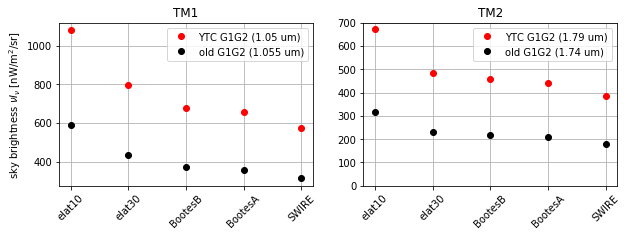

In [2]:
# reduc_generate_flightcal.m, psf_from_stack.m, get_quick_psf.m
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

fig, ax = plt.subplots(1,2,figsize=(10,3))

inst = 1
xlabel=[]
cf_mz = -1.5459 * 110.2
for ifield in [4,5,6,7,8]:
    xlabel.append(fieldnamedict[ifield])
    DCsubmap,mapi, strmask,mask_inst, cf = load_processed_images(data_maps, 
                          return_names=[(inst,ifield,'DCsubmap'),
                                        (inst,ifield,'map'),
                                        (inst,ifield,'strmask'),
                                        (inst,ifield,'mask_inst'),
                                        (inst,ifield,'cf')])
    meanI = np.mean((mapi[mask_inst*strmask==1]))
    ax[0].plot([ifield],[meanI*cf],'ro',label='YTC G1G2 (1.05 um)')
    ax[0].plot([ifield],[meanI*cf_mz],'ko',label='old G1G2 (1.055 um)')
    if ifield==4:
        ax[0].legend()
# ax[0].set_ylim([0,700])
ax[0].grid()
ax[0].set_xticks([4,5,6,7,8])
ax[0].set_ylabel(r'sky brightness $\nu I_\nu$ [nW/m$^2$/sr]')
ax[0].set_xticklabels(xlabel,rotation = 45)
ax[0].set_title('TM1')
inst = 2
xlabel=[]
cf_mz = -1.3181 * 43.4
for ifield in [4,5,6,7,8]:
    xlabel.append(fieldnamedict[ifield])
    DCsubmap,mapi, strmask,mask_inst, cf = load_processed_images(data_maps, 
                          return_names=[(inst,ifield,'DCsubmap'),
                                        (inst,ifield,'map'),
                                        (inst,ifield,'strmask'),
                                        (inst,ifield,'mask_inst'),
                                        (inst,ifield,'cf')])
    meanI = np.mean((mapi[mask_inst*strmask==1]))
    ax[1].plot([ifield],[meanI*cf],'ro',label='YTC G1G2 (1.79 um)')
    ax[1].plot([ifield],[meanI*cf_mz],'ko',label='old G1G2 (1.74 um)')
    if ifield==4:
        ax[1].legend()
ax[1].set_ylim([0,700])
ax[1].grid()
ax[1].set_xticks([4,5,6,7,8])
ax[1].set_xticklabels(xlabel,rotation = 45)
ax[1].set_title('TM2')
plt.savefig('/Users/ytcheng/Desktop/calfac_test',dpi=150,bbox_inches='tight')

In [23]:
from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}


xlabel=[]
cf_mz = -1.5459 * 110.2
for inst in [1,2]:
    
    for ifield in [4,5,6,7,8]:
        cal = cal_factor_dict['apf2nWpm2psr'][inst][ifield]
        xlabel.append(fieldnamedict[ifield])
        DCsubmap,mapi, strmask,mask_inst, cf = load_processed_images(data_maps, 
                              return_names=[(inst,ifield,'DCsubmap'),
                                            (inst,ifield,'map'),
                                            (inst,ifield,'strmask'),
                                            (inst,ifield,'mask_inst'),
                                            (inst,ifield,'cf')])
        meanI = np.mean((mapi[mask_inst*strmask==1]))
        sigmaI = np.std((mapi[mask_inst*strmask==1]))
        
        print('TM%d, ifield=%d, %.2f ADU/fr, %.2f e-/s, (sig)%.2f e-/s, sig/avg=%.2f, %.2f nW/m2/sr'\
              %(inst,ifield,meanI,meanI*cal_factor_dict['apf2eps'][inst],
                -sigmaI*cal_factor_dict['apf2eps'][inst],-sigmaI/meanI,meanI*cal))
    print('==========')

TM1, ifield=4, -3.47 ADU/fr, 5.36 e-/s, (sig)0.58 e-/s, sig/avg=0.11, 1080.38 nW/m2/sr
TM1, ifield=5, -2.55 ADU/fr, 3.94 e-/s, (sig)0.78 e-/s, sig/avg=0.20, 794.07 nW/m2/sr
TM1, ifield=6, -2.17 ADU/fr, 3.36 e-/s, (sig)0.38 e-/s, sig/avg=0.11, 675.82 nW/m2/sr
TM1, ifield=7, -2.10 ADU/fr, 3.25 e-/s, (sig)0.37 e-/s, sig/avg=0.11, 654.71 nW/m2/sr
TM1, ifield=8, -1.84 ADU/fr, 2.84 e-/s, (sig)0.35 e-/s, sig/avg=0.12, 572.88 nW/m2/sr
TM2, ifield=4, -5.55 ADU/fr, 7.32 e-/s, (sig)0.58 e-/s, sig/avg=0.08, 672.29 nW/m2/sr
TM2, ifield=5, -4.01 ADU/fr, 5.29 e-/s, (sig)0.73 e-/s, sig/avg=0.14, 485.85 nW/m2/sr
TM2, ifield=6, -3.78 ADU/fr, 4.99 e-/s, (sig)0.44 e-/s, sig/avg=0.09, 458.01 nW/m2/sr
TM2, ifield=7, -3.63 ADU/fr, 4.79 e-/s, (sig)0.41 e-/s, sig/avg=0.08, 439.86 nW/m2/sr
TM2, ifield=8, -3.17 ADU/fr, 4.18 e-/s, (sig)0.37 e-/s, sig/avg=0.09, 383.55 nW/m2/sr


In [282]:
for inst in [1,2]:
    print('band %d apf2nWpm2psr:\n'%inst)
    for ist, stampsize in enumerate(stampsize_arr):
        calfac_avg = 0
        for ifield in [4,5,6,7,8]:
            calfac = calfac_data[inst][ifield][ist]
            calfac_avg += calfac/5
        if stampsize==5:
            for i,ifield in enumerate([4,5,6,7,8]):
                if i!=0:
                    print(', ', end='')
                print('%d:-%.2f'%(ifield,calfac_avg), end='')
            print('\n\n')

band 1 apf2nWpm2psr:

4:-311.35, 5:-311.35, 6:-311.35, 7:-311.35, 8:-311.35


band 2 apf2nWpm2psr:

4:-121.09, 5:-121.09, 6:-121.09, 7:-121.09, 8:-121.09




In [6]:
# from utils import *
# cal_factor_dict_old = {
#                    'apf2nWpm2psr':{
#                                    1:{4:-448.60, 5:-333.58, 6:-461.59, 7:-339.27, 8:-361.43},
#                                    2:{4:-122.28, 5:-118.09, 6:-137.84, 7:-111.95, 8:-115.39},
#                                   }
#                   }
# for inst in [1,2]:
#     filt_order=filt_order_dict[inst]
#     for ifield in [4,5,6,7,8]:
#         c = cal_factor_dict['apf2nWpm2psr'][inst][ifield] \
#         / cal_factor_dict_old['apf2nWpm2psr'][inst][ifield]
#         field = fieldnamedict[ifield]

#         for i,im in enumerate([0,1,2,3]):
#             m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
#             loaddir = './stack_data/'
#             savename = loaddir + 'stackdat_TM%d_%s_%d_%d_filt%d'\
#             %(inst, field, m_min, m_max, filt_order)
#             stackdat = np.load(savename + '.npy' ,allow_pickle='TRUE').item()

#             stackdat['profcb']*= c
#             stackdat['profcbsub']*= c
#             stackdat['profcb100']*= c
#             stackdat['BG']['profcb']*= c
#             stackdat['BG']['profcbsub']*= c
#             stackdat['BG']['profcb100']*= c

#             for isub in list(stackdat['sub']):
#                 stackdat['sub'][isub]['profcb']*=c
#                 stackdat['sub'][isub]['profcbsub']*= c
#                 stackdat['sub'][isub]['profcb100']*= c
#                 stackdat['BG'][isub]['profcb']*=c
#                 stackdat['BG'][isub]['profcbsub']*= c
#                 stackdat['BG'][isub]['profcb100']*= c 
            
#             np.save(savename, stackdat)

#         for i,(im,Mabs_min,Mabs_max) in enumerate(zip([1,2,3,2,3],
#                                                 [-23,-23,-23,-22,-22],
#                                                 [-22,-22,-22,-21,-21])):
#             m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
#             loaddir = './stack_data/'
#             savename = loaddir + 'stackdat_TM%d_%s_%d_%d_filt%d_Mabs%d_%d'\
#             %(inst, field, m_min, m_max, filt_order, Mabs_min, Mabs_max)
#             stackdat = np.load(savename + '.npy' ,allow_pickle='TRUE').item()

#             stackdat['profcb']*= c
#             stackdat['profcbsub']*= c
#             stackdat['profcb100']*= c
#             stackdat['BG']['profcb']*= c
#             stackdat['BG']['profcbsub']*= c
#             stackdat['BG']['profcb100']*= c

#             for isub in list(stackdat['sub']):
#                 stackdat['sub'][isub]['profcb']*=c
#                 stackdat['sub'][isub]['profcbsub']*= c
#                 stackdat['sub'][isub]['profcb100']*= c
#                 stackdat['BG'][isub]['profcb']*=c
#                 stackdat['BG'][isub]['profcbsub']*= c
#                 stackdat['BG'][isub]['profcb100']*= c
                
#             np.save(savename, stackdat)

In [7]:
# from utils import *
# cal_factor_dict_old = {
#                    'apf2nWpm2psr':{
#                                    1:{4:-448.60, 5:-333.58, 6:-461.59, 7:-339.27, 8:-361.43},
#                                    2:{4:-122.28, 5:-118.09, 6:-137.84, 7:-111.95, 8:-115.39},
#                                   }
#                   }
# for inst in [1,2]:
#     savedir = './mcmc_data/TM%d/'%inst
#     for ifield in [4,5,6,7,8]:
#         c = cal_factor_dict['apf2nWpm2psr'][inst][ifield] \
#         / cal_factor_dict_old['apf2nWpm2psr'][inst][ifield]
#         field = fieldnamedict[ifield]
#         savenames = []
#         savenames.append('mcmc_3par_%s_m16_17_sub.npy'%field)
#         savenames.append('mcmc_3par_%s_m17_18.npy'%field)
#         savenames.append('mcmc_3par_%s_m18_19.npy'%field)
#         savenames.append('mcmc_3par_%s_m19_20.npy'%field)
#         savenames.append('mcmc_3par_%s_m17_20.npy'%field)
#         savenames.append('mcmc_3par_%s_m17_18_Mabs-23_-22.npy'%field)
#         savenames.append('mcmc_3par_%s_m18_19_Mabs-22_-21.npy'%field)
#         savenames.append('mcmc_3par_%s_m18_19_Mabs-23_-22.npy'%field)
#         savenames.append('mcmc_3par_%s_m19_20_Mabs-22_-21.npy'%field)
#         savenames.append('mcmc_3par_%s_m19_20_Mabs-23_-22.npy'%field)
#         for savename in savenames:
#             chains = np.load(savedir+savename)
#             chains[:,:,1] = chains[:,:,1] * c
#             chains[:,:,2] = chains[:,:,2] * c
#             np.save(savedir+savename,chains)

In [40]:
# from srcmap import *
# from mask import *
# from power_spec import *
# from micecat import *

# psfmaps = {}
# for inst in [1,2]:
#     psfmaps[inst] = {}
#     for ifield in [4,5,6,7,8]:
#         print(inst, ifield)
#         make_srcmap_class1 = make_srcmap(inst,psf_ifield=ifield)
#         make_srcmap_class1.ms = np.array([1])
#         make_srcmap_class1.xls = np.array([200])
#         make_srcmap_class1.yls = np.array([200])
#         srcmapb1 = make_srcmap_class1.run_srcmap(ptsrc=True, verbose=False)
#         psfmaps[inst][fieldnamedict[ifield]]=srcmapb1[:401,:401]
# fname = '/Users/ytcheng/Downloads/psfmaps.pkl'
# with open(fname, "wb") as f:
#     psfmaps = pickle.dump(psfmaps, f)
# clear_output()